In [1]:
import tensorflow as tf
from tensorflow import keras

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

from cleverhans.attacks import FastGradientMethod
from cleverhans.compat import flags
from cleverhans.dataset import MNIST
from cleverhans.utils import AccuracyReport
from cleverhans.utils_keras import cnn_model
from cleverhans.utils_keras import KerasModelWrapper

from cleverhans.attacks import FastGradientMethod
from cleverhans.augmentation import random_horizontal_flip, random_shift
from cleverhans.compat import flags
from cleverhans.dataset import CIFAR10
from cleverhans.loss import CrossEntropy
from cleverhans.model_zoo.all_convolutional import ModelAllConvolutional
from cleverhans.train import train
from cleverhans.utils import AccuracyReport, set_log_level
from cleverhans.utils_tf import model_eval
import logging

In [2]:
import pandas as pd
import numpy as np
from scipy.stats import entropy
import sys
sys.path.append('..')
sys.path.append('../odcd/cd/')
sys.path.append('../odcd/utils/')
import matplotlib
import seaborn as sns
from creme.stats import Mean, Var
import matplotlib.pyplot as plt
import model_symmetries as vsf
%matplotlib inline

from skmultiflow.drift_detection.adwin import ADWIN
from scipy.stats import percentileofscore

import streaming_sim_test as sst
from importlib import reload

import colorama
from colorama import Fore, Style

Using TensorFlow backend.


In [3]:
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, Dropout, Input, Activation
from keras.callbacks import ModelCheckpoint, EarlyStopping
import numpy as np

#from art.attacks import DeepFool, CarliniL2Method, CarliniLInfMethod, ElasticNet
#from art.attacks import NewtonFool, CarliniLInfMethod

import art.attacks as attacks

from art.classifiers import KerasClassifier
from art.utils import load_dataset
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import precision_score, recall_score, accuracy_score, precision_recall_curve

# Mnist

### fgsm

In [4]:
def get_adversarial_acc_metric(model, fgsm, fgsm_params):
  def adv_acc(y, _):
    # Generate adversarial examples
    x_adv = fgsm.generate(model.input, **fgsm_params)
    # Consider the attack to be constant
    x_adv = tf.stop_gradient(x_adv)

    # Accuracy on the adversarial examples
    preds_adv = model(x_adv)
    return keras.metrics.categorical_accuracy(y, preds_adv)

  return adv_acc

In [5]:
train_start=0
train_end=60000
test_start=0
test_end=10000
nb_epochs=50
batch_size=128
learning_rate=0.001
testing=False
label_smoothing=0.1
fashion=False

In [17]:
report = AccuracyReport()

  # Set TF random seed to improve reproducibility
tf.set_random_seed(1234)
  # Force TensorFlow to use single thread to improve reproducibility
config = tf.ConfigProto(intra_op_parallelism_threads=1,
                          inter_op_parallelism_threads=1)


sess = tf.Session(config=config)
keras.backend.set_session(sess)

  # Get MNIST test data
    
if fashion:
    (X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

    np.random.seed(0)
    X_train = X_train.astype('float32') / 255
    X_test = X_test.astype('float32') / 255
    X_train = np.reshape(X_train, X_train.shape + (1,))
    X_test = np.reshape(X_test, X_test.shape + (1,))
    y_train = tf.keras.utils.to_categorical(y_train)
    y_test = tf.keras.utils.to_categorical(y_test)
    
else:
    mnist = MNIST(train_start=train_start, train_end=train_end,
                test_start=test_start, test_end=test_end)
    X_train, y_train = mnist.get_set('train')
    X_test, y_test = mnist.get_set('test')

  # Obtain Image Parameters
img_rows, img_cols, nchannels = X_train.shape[1:4]
nb_classes = y_train.shape[1]

  # Label smoothing
y_train -= label_smoothing * (y_train - 1. / nb_classes)

print('x_train shape:', X_train.shape, 'x_test shape:', X_test.shape)
print('y_train shape:', y_train.shape, 'y_test shape:', y_test.shape)
  # Define Keras model
model = cnn_model(img_rows=img_rows, img_cols=img_cols,
                    channels=nchannels, nb_filters=64,
                    nb_classes=nb_classes)
print("Defined Keras model.")

  # To be able to call the model in the custom loss, we need to call it once
  # before, see https://github.com/tensorflow/tensorflow/issues/23769
model(model.input)

  # Initialize the Fast Gradient Sign Method (FGSM) attack object
wrap = KerasModelWrapper(model)
fgsm = FastGradientMethod(wrap, sess=sess)
fgsm_params = {'eps': 0.3,
                 'clip_min': 0.,
                 'clip_max': 1.}

adv_acc_metric = get_adversarial_acc_metric(model, fgsm, fgsm_params)
model.compile(
      optimizer=keras.optimizers.Adam(learning_rate),
      loss='categorical_crossentropy',
      metrics=['accuracy', adv_acc_metric]
  )

x_train shape: (60000, 28, 28, 1) x_test shape: (10000, 28, 28, 1)
y_train shape: (60000, 10) y_test shape: (10000, 10)
Defined Keras model.


/home/Gigio/git/fork-cleverhans/cleverhans/attacks_tf.py:27: UserWarning: attacks_tf is deprecated and will be removed on 2019-07-18 or after. Code should import functions from their new locations directly.
  warnings.warn("attacks_tf is deprecated and will be removed on 2019-07-18"
/home/Gigio/git/fork-cleverhans/cleverhans/compat.py:22: UserWarning: <function reduce_max at 0x7f7f2dd8a2f0> is deprecated. Switch to calling the equivalent function in tensorflow.  This function was originally needed as a compatibility layer for old versions of tensorflow,  but support for those versions has now been dropped.
  warnings.warn(str(f) + " is deprecated. Switch to calling the equivalent function in tensorflow. "
/home/Gigio/git/fork-cleverhans/cleverhans/compat.py:22: UserWarning: <function reduce_sum at 0x7f7f2dd87a60> is deprecated. Switch to calling the equivalent function in tensorflow.  This function was originally needed as a compatibility layer for old versions of tensorflow,  but supp

In [4]:
#model.fit(X_train, y_train,
#            batch_size=batch_size,
#            epochs=nb_epochs,
#            validation_data=(X_test, y_test),
#            verbose=1)


In [ ]:
X_adv = sess.run(fgsm.generate(model.input, **fgsm_params), feed_dict={model.input: X_test})
y_adv = y_test

In [ ]:
idx = 1042
x = X_test[idx: idx + 1]
plt.imshow(np.squeeze(x), 'gray')
print('Sample instance from the MNIST data set.')

In [ ]:
xa = X_adv[idx: idx + 1]
plt.imshow(np.squeeze(xa), 'gray')
print('Sample instance from the MNIST data set.')

In [ ]:
model.predict(x)

In [ ]:
model.predict(xa)

In [26]:
reload(vsf)

<module 'model_symmetries' from '../odcd/cd/model_symmetries.py'>

In [27]:
vae = vsf.VaeSymmetryFinderConv(model, input_shape=(28, 28, 1), rgb_filters=1,
                            output_shape=(10, ), nb_conv_layers=2, lr=0.001,
                            intermediate_dim=256, variational=True, opt='RMSprop',
                            latent_dim=8, loss_type='symm', add_latent_loss=False)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 14, 14, 64)   640         encoder_input[0][0]              
__________________________________________________________________________________________________
dropout_13 (Dropout)            (None, 14, 14, 64)   0           conv2d_9[0][0]                   
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 7, 7, 128)    73856       dropout_13[0][0]                 
__________________________________________________________________________________________________
dropout_14

### Deep fool / Carlini

In [4]:
def prepare_data_mnist(fashion=False):
    
    if fashion:
        (X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
    else:
        (X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
    print('x_train shape:', X_train.shape, 'y_train shape:', y_train.shape)

    # define train and test set
    np.random.seed(0)
    X_train = X_train.astype('float32') / 255
    X_test = X_test.astype('float32') / 255
    X_train = np.reshape(X_train, X_train.shape + (1,))
    X_test = np.reshape(X_test, X_test.shape + (1,))
    y_train = tf.keras.utils.to_categorical(y_train)
    y_test = tf.keras.utils.to_categorical(y_test)

        
    print(X_train.shape, y_train.shape)
    print(X_test.shape, y_test.shape)

    return X_train, y_train, X_test, y_test
    

In [5]:
def model_mnist_keras(nb_classes=10):
    x_in = Input(shape=(28, 28, 1))
    x = Conv2D(filters=64, kernel_size=2, padding='same', activation='relu')(x_in)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)

    x = Conv2D(filters=32, kernel_size=2, padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)

    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(nb_classes, name='logits')(x)
    x_out = Activation('softmax', name='softmax')(x)
    
    cnn = Model(inputs=x_in, outputs=x_out)
    cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return cnn

In [289]:
X_train, y_train, X_test, y_test = prepare_data_mnist(fashion=False)
X_test, y_test = X_test[:500], y_test[:500]
min_, max_ = X_train.min(), X_train.max()

x_train shape: (60000, 28, 28) y_train shape: (60000,)
(60000, 28, 28, 1) (60000, 10)
(10000, 28, 28, 1) (10000, 10)


Sample instance from the MNIST data set.


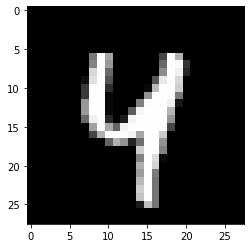

In [290]:
idx = 42
x = X_test[idx: idx + 1]
plt.imshow(np.squeeze(x), 'gray')
print('Sample instance from the MNIST data set.')

In [291]:
m = model_mnist_keras()
model = KerasClassifier(model=m, clip_values=(min_, max_))
model.fit(X_train, y_train, nb_epochs=10, batch_size=128)

Epoch 1/10
469/468 [==============================] - 4s 8ms/step - loss: 0.3882 - acc: 0.8774
Epoch 2/10
469/468 [==============================] - 3s 6ms/step - loss: 0.1344 - acc: 0.9578
Epoch 3/10
469/468 [==============================] - 3s 6ms/step - loss: 0.1008 - acc: 0.9692
Epoch 4/10
469/468 [==============================] - 3s 6ms/step - loss: 0.0875 - acc: 0.9719
Epoch 5/10
469/468 [==============================] - 3s 6ms/step - loss: 0.0731 - acc: 0.9764
Epoch 6/10
469/468 [==============================] - 3s 6ms/step - loss: 0.0637 - acc: 0.9796
Epoch 7/10
469/468 [==============================] - 3s 6ms/step - loss: 0.0606 - acc: 0.9807
Epoch 8/10
469/468 [==============================] - 3s 6ms/step - loss: 0.0555 - acc: 0.9821
Epoch 9/10
469/468 [==============================] - 3s 6ms/step - loss: 0.0550 - acc: 0.9827
Epoch 10/10
469/468 [==============================] - 3s 6ms/step - loss: 0.0524 - acc: 0.9833


In [292]:
# Craft adversarial samples with DeepFool
#print('Create DeepFool attack')
#adv_crafter = DeepFool(model, epsilon=0.1)

In [293]:
mean_confidence = np.max(m.predict(X_test), axis=1).mean()

In [294]:
mean_confidence

0.9894865

In [12]:
reload(attacks)

<module 'art.attacks' from '/home/Gigio/git/fork-art/art/attacks/__init__.py'>

In [295]:
# Craft adversarial samples with Carlini attack
print('Create Carlini attack')
#adv_crafter = CarliniL2Method(model, confidence=mean_confidence)
#adv_crafter = CarliniLInfMethod(model, confidence=mean_confidence)
adv_crafter = attacks.CarliniLInfMethod(model, X_train, nb_samples=100, beta=0)

Create Carlini attack
800A


In [296]:
# Craft adversarial samples with hclu attack
#print('Create hclu attack')
#adv_crafter = HighConfidenceLowUncertainty(model, confidence=mean_confidence)


In [297]:
print('Craft attack test examples')
print('Method', type(adv_crafter))
X_test_adv = adv_crafter.generate(X_test)
y_test_adv = y_test
print('Done')

Craft attack test examples
Method <class 'art.attacks.carlini.CarliniLInfMethod'>
10.815186906605959 22.560715255923856
0 10.815186906605959
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
10.798533373395912 22.56071647353751
0 10.798533373395912
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
10.781894004205242 22.56071772475856
0 10.781894004205242
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
10.748653365473729 22.560720442473766
0 10.748653365473729
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
10.68255691457307 22.56072760227244
0 10.68255691457307
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
10.553681329882238 22.560748823998544
0 10.553681329882238
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
10.303212327649817 22.5607939591208
0 10.303212327649817
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
10.303212342434563 22.56066899163466
0 10.303212342434563
+++++++++++++++++++++++++++++++++++++++++

2.3633286699430265 22.560523043627207
0 2.3633286699430265
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
2.2779190594499763 22.5624753690195
0 2.2779190594499763
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
1.9562581550507319 22.56577762711664
0 1.9562581550507319
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
1.8392744714563543 22.555328573273606
0 1.8392744714563543
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
2.2199421375989914 22.566498826779835
0 2.2199421375989914
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
2.434571483555962 22.55840773716663
0 2.434571483555962
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
2.4102703549645166 22.562411579723296
0 2.4102703549645166
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
2.7813964698995863 22.55034114761745
0 2.7813964698995863
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
2.959234043955803 22.54880638262884
0 2.959234043955803
+++++++

2.3736014662642186 22.555777100019377
0 2.3736014662642186
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
2.334932232275605 22.550476288725772
0 2.334932232275605
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
2.370706227318994 22.554104036977837
0 2.370706227318994
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
1.892552381157875 22.549039111915203
0 1.892552381157875
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
1.8393048822879792 22.552735095008153
0 1.8393048822879792
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
2.359035987406969 22.5618630607706
0 2.359035987406969
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
2.15202281202959 22.56665587747606
0 2.15202281202959
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
2.2168578575639164 22.566481576319088
0 2.2168578575639164
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
2.0561379875455583 22.559095868175696
0 2.0561379875455583
++++++++++++

2.870493558109612 22.55700420228761
0 2.870493558109612
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
4.41986950317567 22.539161077446916
0 4.41986950317567
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
4.698328414311011 22.544013598034464
0 4.698328414311011
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
6.499398171901703 22.543535794665427
0 6.499398171901703
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
6.450273716449738 22.543515921520555
0 6.450273716449738
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
2.558566011902359 22.55975727912552
0 2.558566011902359
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
2.4200704361688583 22.558252125614988
0 2.4200704361688583
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
2.29162519209479 22.556196027016615
0 2.29162519209479
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
2.0289012080719395 22.548668561595058
0 2.0289012080719395
+++++++++++++++++

5.334697846104117 22.551361678607964
0 5.334697846104117
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
4.815214586316371 22.551112633172824
0 4.815214586316371
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
4.338631063991902 22.55071918823169
0 4.338631063991902
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
4.0321075652200395 22.550777336957847
0 4.0321075652200395
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
3.6558774878149447 22.55196718227787
0 3.6558774878149447
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
3.4071126646080683 22.55384490174011
0 3.4071126646080683
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
3.502561524072114 22.548977039793012
0 3.502561524072114
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
3.286574951931834 22.552504208396744
0 3.286574951931834
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
3.0991907753050327 22.551275355627336
0 3.0991907753050327
++++++++++

In [298]:
# Evaluate the classifier on the adversarial samples
preds = np.argmax(model.predict(X_test), axis=1)
acc = np.sum(preds == np.argmax(y_test, axis=1)) / y_test.shape[0]
preds_adv = np.argmax(model.predict(X_test_adv), axis=1)
acc_adv = np.sum(preds_adv == np.argmax(y_test_adv, axis=1)) / y_test_adv.shape[0]
print('Classifier before adversarial training')
print('Accuracy on test samples: ', acc)
print('Accuracy on adversarial samples: ', acc_adv)

Classifier before adversarial training
Accuracy on test samples:  0.994
Accuracy on adversarial samples:  0.486


Sample instance from the MNIST data set.


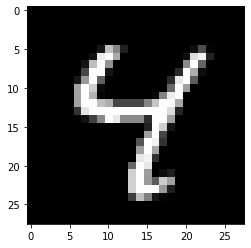

In [299]:
idx = 6
x = X_test[idx: idx + 1]
plt.imshow(np.squeeze(x), 'gray')
print('Sample instance from the MNIST data set.')

Sample instance from the MNIST data set.


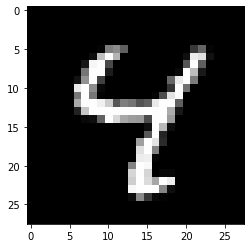

In [300]:
xa = X_test_adv[idx: idx + 1]
plt.imshow(np.squeeze(xa), 'gray')
print('Sample instance from the MNIST data set.')

In [301]:
model.predict(x)

array([[2.1260564e-09, 1.1165840e-06, 2.9484355e-08, 2.3883613e-09,
        9.9884379e-01, 1.3967407e-08, 5.1994662e-09, 1.3808363e-05,
        1.0156516e-03, 1.2546193e-04]], dtype=float32)

In [302]:
model.predict(xa)

array([[1.9711473e-07, 4.7152302e-05, 6.9867551e-06, 1.1153058e-06,
        4.9577668e-01, 1.7885640e-06, 1.9348755e-07, 2.7289803e-04,
        5.0154281e-01, 2.3501499e-03]], dtype=float32)

In [303]:
np.allclose(m.predict(X_test), model.predict(X_test))

True

In [304]:
np.allclose(m.predict(X_test_adv), model.predict(X_test_adv))

True

### nn detection on probability space

In [305]:
from keras import backend as K

In [306]:
inp = m.input
outs = {l.name: l.output for l in m.layers}
predict_fns = {name: K.function([inp], [out]) for name, out in outs.items()}
def predict_fn(x):
    layer = predict_fns['logits']([x])
    return layer[0]

In [307]:
predict_fn(X_test)

array([[ -5.3041735 ,  -1.5167468 ,  -0.4032617 , ...,  15.987928  ,
         -4.7928786 ,   0.93507206],
       [ -2.1697302 ,   6.0985756 ,  18.592377  , ...,  -3.6350698 ,
         -1.8506039 , -11.600155  ],
       [ -4.5685787 ,  10.832044  ,  -3.6545362 , ...,  -2.0524027 ,
         -4.693579  ,  -5.0993576 ],
       ...,
       [ -7.3352284 ,   2.1707828 ,  -3.4582925 , ...,  -4.8981323 ,
          1.0310167 ,   3.083394  ],
       [ 10.711942  ,  -2.36203   ,   0.18869303, ...,   0.45230722,
          3.0410461 ,  -0.19032028],
       [ -0.5211352 ,  -4.3033533 ,  -4.8457394 , ..., -11.278468  ,
          2.0873246 ,  -4.639996  ]], dtype=float32)

In [308]:
def _calculate_perc(df_t, nb_sigmas=3):
    sigma_plus = df_t['test'].mean() + (nb_sigmas * df_t['test'].std())
    print(sigma_plus)
    pc_sigma = percentileofscore(df_t['adv'], sigma_plus) * 0.01
    perc = 1 - pc_sigma
    return perc, sigma_plus

def calculate_perc_nn(X_train, X_test, X_test_adv, predict_fn, nb_samples=100, nb_sigmas=3):
    
    X_train_samples = np.random.permutation(X_train)[:nb_samples]
    preds_train = predict_fn(X_train_samples)
    nn = NearestNeighbors()
    nn.fit(preds_train)
    
    preds_test, preds_adv = predict_fn(X_test), predict_fn(X_test_adv)
    dist_test, idx_test = nn.kneighbors(preds_test, n_neighbors=1)
    dist_adv, idx_adv = nn.kneighbors(preds_adv, n_neighbors=1)

    df_dist = pd.DataFrame()
    df_dist['test'] = dist_test.flatten()
    df_dist['adv'] = dist_adv.flatten()
    
    perc, sigma_plus = _calculate_perc(df_dist, nb_sigmas=nb_sigmas)
    
    return perc, df_dist, sigma_plus

In [309]:
m.predict(x)

array([[2.1260567e-09, 1.1165840e-06, 2.9484356e-08, 2.3883615e-09,
        9.9884391e-01, 1.3967409e-08, 5.1994662e-09, 1.3808365e-05,
        1.0156517e-03, 1.2546194e-04]], dtype=float32)

In [310]:
nbs = []
percs = []
def predict_fn(x):
    return m.predict(x)
for nb_samples in [10, 50, 100, 200, 300, 400, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000]:
    print(nb_samples)
    perc, df_dist, sigma_plus = calculate_perc_nn(X_train, X_test, X_test_adv, 
                                                  predict_fn, nb_samples=nb_samples, nb_sigmas=5)
    print(perc)
    nbs.append(nb_samples)
    percs.append(perc)
df_curve = pd.DataFrame()
df_curve['nb_samples'] = nbs
df_curve['percs'] = percs

10
4.143965363502502
0.0
50
0.3761645001055559
0.47
100
0.33299070064382685
0.45200000000000007
200
0.3103956384587017
0.45799999999999996
300
0.3021978703120682
0.42200000000000004
400
0.24693643878655383
0.43200000000000005
500
0.3172880719695777
0.4179999999999999
1000
0.26408481121774535
0.348
1500
0.26032655959720113
0.31400000000000006
2000
0.2200075816369194
0.29000000000000004
2500
0.18094294377542994
0.31999999999999995
3000
0.25876236682976606
0.2759999999999999
3500
0.18458703208098964
0.262
4000
0.18846126742552172
0.238
4500
0.14608191771398957
0.29000000000000004
5000
0.18314406435866157
0.28200000000000003


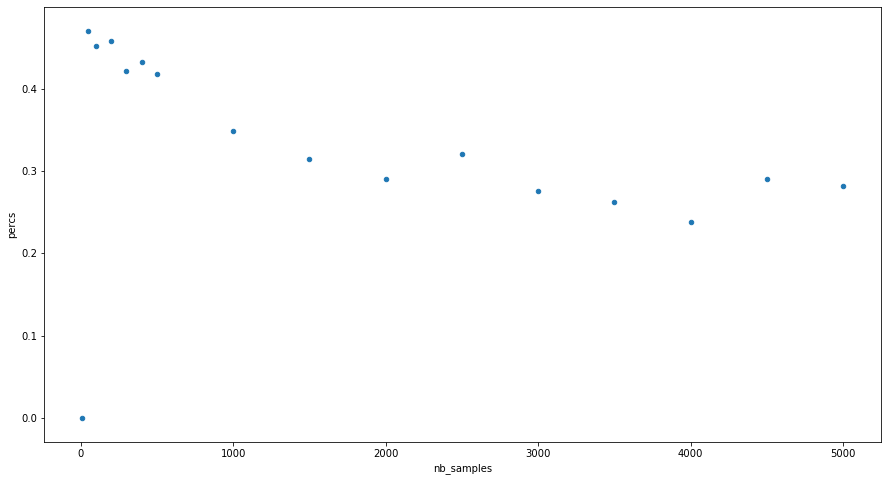

In [311]:
df_curve.plot(kind='scatter', x='nb_samples', y='percs', logx=False, figsize=(15, 8))

In [312]:
perc, df_dist, sigma_plus = calculate_perc_nn(X_train, X_test, X_test_adv, predict_fn, nb_samples=1000, nb_sigmas=5)

0.26070540246620694


In [313]:
perc

0.386

In [314]:
df_dist.describe(percentiles=[0.5, 0.9, 1-perc])

,test,adv
count,5.000000e+02,5.000000e+02
mean,8.983226e-03,1.912871e-01
std,5.034444e-02,2.184750e-01
min,7.295405e-10,7.295405e-10
50%,1.001707e-05,4.569436e-02
61.4%,3.454976e-05,2.564801e-01
90%,2.927692e-03,5.231715e-01
max,4.826784e-01,6.225465e-01


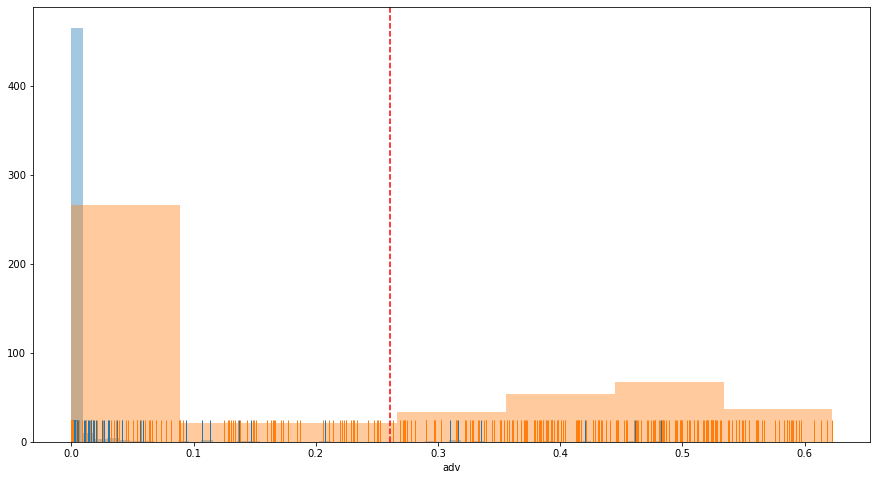

In [315]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.distplot(df_dist['test'], rug=True, ax=ax, kde=False)
plt.axvline(sigma_plus, c='r', linestyle='dashed')
sns.distplot(df_dist['adv'], rug=True,ax=ax, kde=False)

In [316]:
dist_test, dist_adv = df_dist['test'].values, df_dist['adv'].values

In [317]:
x_bl =  np.concatenate((dist_test, dist_adv))
y_bl = np.concatenate((np.zeros(len(dist_test)), np.ones(len(dist_adv))))
x_bl = x_bl / x_bl.max()

In [318]:
min_bl = dist_test.mean()
max_bl = dist_adv.mean() + 10 * dist_adv.std()

### define vae

In [319]:
reload(vsf)

<module 'model_symmetries' from '../odcd/cd/model_symmetries.py'>

In [484]:
vae = vsf.VaeSymmetryFinderConvKeras(m, input_shape=(28, 28, 1), rgb_filters=1, dropout=None, 
                                     output_shape=(10, ), nb_conv_layers=2, lr=0.001, strides=2, 
                                     filters=28, intermediate_dim=512, variational=True, opt='Adam', 
                                     pooling=False, padding='same', latent_dim=1024, loss_type='kl_1', 
                                     add_latent_loss=False)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 14, 14, 56)   560         encoder_input[0][0]              
__________________________________________________________________________________________________
conv2d_22 (Conv2D)              (None, 7, 7, 112)    56560       conv2d_21[0][0]                  
__________________________________________________________________________________________________
flatten_11 (Flatten)            (None, 5488)         0           conv2d_22[0][0]                  
__________________________________________________________________________________________________
z_mean (De

## Detect through symmetry 

In [485]:
mcp = ModelCheckpoint('vae_weights_mnist_adv.h5', 
                      monitor='val_loss', 
                      verbose=1, 
                      save_best_only=True, 
                      save_weights_only=True, 
                      mode='auto', period=1)
es = EarlyStopping(monitor='val_loss', patience=30, verbose=1, mode='auto')

In [486]:
vae.fit(X_train, x_test=X_test, epochs=50, callbacks=[mcp, es])

Train on 60000 samples, validate on 500 samples
Epoch 1/50
60000/60000 [==============================] - 14s 229us/step - loss: 0.4978 - val_loss: 0.0769

Epoch 00001: val_loss improved from inf to 0.07689, saving model to vae_weights_mnist_adv.h5
Epoch 2/50
60000/60000 [==============================] - 9s 153us/step - loss: 0.1147 - val_loss: 0.0630

Epoch 00002: val_loss improved from 0.07689 to 0.06299, saving model to vae_weights_mnist_adv.h5
Epoch 3/50
60000/60000 [==============================] - 9s 153us/step - loss: 0.0922 - val_loss: 0.0408

Epoch 00003: val_loss improved from 0.06299 to 0.04078, saving model to vae_weights_mnist_adv.h5
Epoch 4/50
60000/60000 [==============================] - 9s 153us/step - loss: 0.0828 - val_loss: 0.0473

Epoch 00004: val_loss did not improve from 0.04078
Epoch 5/50
60000/60000 [==============================] - 9s 152us/step - loss: 0.0773 - val_loss: 0.0393

Epoch 00005: val_loss improved from 0.04078 to 0.03935, saving model to vae_we

60000/60000 [==============================] - 9s 153us/step - loss: 0.0558 - val_loss: 0.0164

Epoch 00049: val_loss improved from 0.01654 to 0.01641, saving model to vae_weights_mnist_adv.h5
Epoch 50/50
60000/60000 [==============================] - 9s 154us/step - loss: 0.0559 - val_loss: 0.0150

Epoch 00050: val_loss improved from 0.01641 to 0.01499, saving model to vae_weights_mnist_adv.h5


In [487]:
vae.save(arch_path='vae_arch_mnist_adv.json', weights_path='vae_weights_mnist_adv_2.h5', save_model_only=True)

In [488]:
vae_loaded = vsf.load_vae(arch_path='vae_arch_mnist_adv.json', 
                          weights_path='vae_weights_mnist_adv.h5', 
                         model_type='keras', signal_type='kl_1')
#vae_loaded = vae

Loaded model from disk


## Stream

In [489]:
# Symmetry signal
#X_train_perm = np.random.permutation(X_train)
#X_test_perm = np.random.permutation(X_test)
#X_adv_perm = np.random.permutation(X_adv)

amp = 1
n = 10
kl_train = vae_loaded.signal(X_train, amp=amp, nb_samples=n)
kl_test = vae_loaded.signal(X_test, amp=amp, nb_samples=n)
kl_adv = vae_loaded.signal(X_test_adv, amp=amp, nb_samples=n)

baseline_std_plus = kl_train.mean() + kl_train.std()
baseline_std_minus = kl_train.mean() - kl_train.std()

kl_concat = np.concatenate((kl_test, kl_adv))
bl_concat =  np.concatenate((dist_test, dist_adv))
tr = kl_test.shape[0]

baseline_std_plus_bl = dist_test.mean() + dist_test.std()
baseline_std_minus_bl = dist_test.mean() - dist_test.std()

In [490]:
vae_loaded.predict_original(x)

array([[2.1260567e-09, 1.1165840e-06, 2.9484356e-08, 2.3883615e-09,
        9.9884391e-01, 1.3967409e-08, 5.1994662e-09, 1.3808365e-05,
        1.0156517e-03, 1.2546194e-04]], dtype=float32)

In [491]:
vae_loaded.transform_predict(x)

array([[8.2982488e-06, 1.5795794e-04, 5.1063882e-05, 8.7155449e-06,
        9.9085039e-01, 5.2622854e-05, 1.7153068e-05, 4.3655036e-04,
        1.4672180e-03, 6.9498727e-03]], dtype=float32)

In [492]:
vae_loaded.predict_original(xa)

array([[1.9711473e-07, 4.7152298e-05, 6.9867551e-06, 1.1153058e-06,
        4.9577668e-01, 1.7885640e-06, 1.9348755e-07, 2.7289803e-04,
        5.0154281e-01, 2.3501499e-03]], dtype=float32)

In [493]:
vae_loaded.transform_predict(xa)

array([[2.1089074e-04, 9.1427745e-04, 3.8510974e-04, 8.2863859e-05,
        9.2177230e-01, 4.9976591e-04, 3.6023540e-04, 1.5857994e-03,
        5.5340748e-02, 1.8848060e-02]], dtype=float32)

In [494]:
print(kl_train.mean(), kl_train.std())

0.0121047925 0.055225004


In [495]:
print(kl_test.mean(), kl_test.std())

0.014451244 0.058612224


In [496]:
print(kl_adv.mean(), kl_adv.std())

0.4957928 0.7037944


In [497]:
kl_adv.shape

(500,)

### Detector curves

In [520]:
perm = np.random.permutation(range(len(kl_adv)))[:50]
x_kl = np.concatenate((kl_test, kl_adv[perm]))
y_kl = np.concatenate((np.zeros(len(kl_test)), np.ones(len(kl_adv[perm]))))
x_kl = x_kl / x_kl.max()

In [521]:
x_bl =  np.concatenate((dist_test, dist_adv[perm]))
y_bl = np.concatenate((np.zeros(len(dist_test)), np.ones(len(dist_adv[perm]))))
x_bl = x_bl / x_bl.max()

In [522]:
bs_acc = 1 - y_bl.sum() / len(y_bl)
bs_acc

0.9090909090909091

In [523]:
(kl_train / kl_train.max()).mean() + 1 * (kl_train / kl_train.max()).std()

0.023036199156194925

In [524]:
trs = np.arange(0, 1, 0.001)

In [525]:
#X_train_samples = np.random.permutation(X_train)[:100]
#preds_train = predict_fn(X_train_samples)
#nn = NearestNeighbors()
#nn.fit(preds_train)
    
#preds_test, preds_adv = predict_fn(X_test), predict_fn(X_test_adv)
#dist_test, idx_test = nn.kneighbors(preds_test, n_neighbors=1)
#dist_adv, idx_adv = nn.kneighbors(preds_adv, n_neighbors=1)

In [526]:
#x_bl =  np.concatenate((dist_test, dist_adv))
#y_bl = np.concatenate((np.zeros(len(dist_test)), np.ones(len(dist_adv))))

(0.0, 1.0)

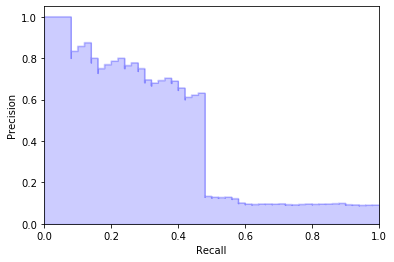

In [527]:
from inspect import signature
precision_bl, recall_bl, thresholds_bl = precision_recall_curve(y_bl, x_bl)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall_bl, precision_bl, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall_bl, precision_bl, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

(0.0, 1.0)

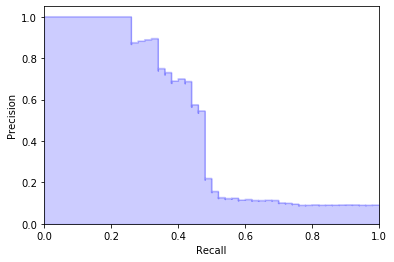

In [528]:
precision, recall, thresholds = precision_recall_curve(y_kl, x_kl)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

In [507]:
trs = np.arange(0, 1, 0.001)

In [508]:
def predict_adv(x, tr):
    return (x > tr).astype(int)

In [509]:
from sklearn.metrics import f1_score

In [510]:
tresholds, precs, recals, accs, f1s = [], [], [], [], []
precs_bl, recals_bl, accs_bl, f1s_bl = [], [], [], []
for tr in trs:
    preds_kl = predict_adv(x_kl, tr)
    preds_bl = predict_adv(x_bl, tr)
    
    prec = precision_score(y_kl, preds_kl)
    rec = recall_score(y_kl, preds_kl)
    acc = accuracy_score(y_kl, preds_kl)
    f1 = f1_score(y_kl, preds_kl)
    
    prec_bl = precision_score(y_bl, preds_bl)
    rec_bl = recall_score(y_bl, preds_bl)
    acc_bl = accuracy_score(y_bl, preds_bl)
    f1_bl = f1_score(y_bl, preds_bl)
    
    tresholds.append(tr)
    precs.append(prec)
    recals.append(rec)
    accs.append(acc)
    f1s.append(f1)
    
    precs_bl.append(prec_bl)
    recals_bl.append(rec_bl)
    accs_bl.append(acc_bl)
    f1s_bl.append(f1_bl)

df_scores = pd.DataFrame()
df_scores['trs'] = tresholds
df_scores['precs'] = precs
df_scores['recs'] = recals
df_scores['accs'] = accs
df_scores['f1s'] = f1s

df_scores['precs_bl'] = precs_bl
df_scores['recs_bl'] = recals_bl
df_scores['accs_bl'] = accs_bl
df_scores['f1s_bl'] = f1s_bl

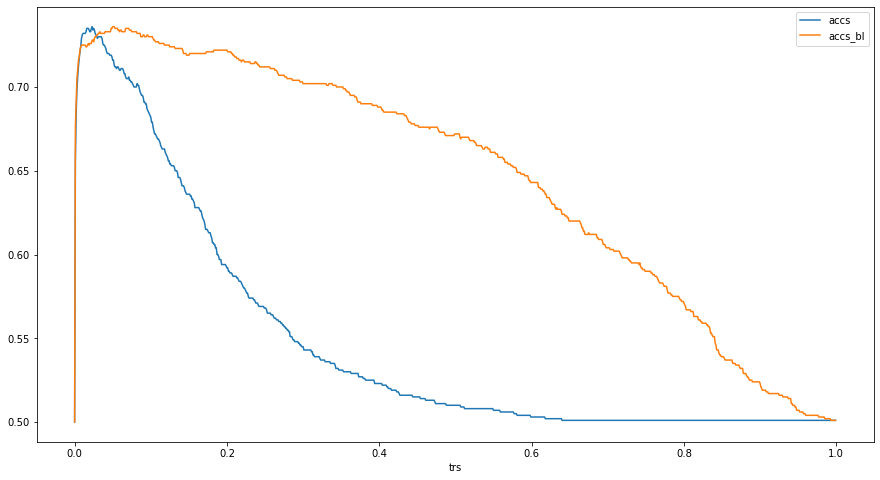

In [511]:
df_scores.plot(x= 'trs',y=['accs', 'accs_bl'], figsize=(15, 8))

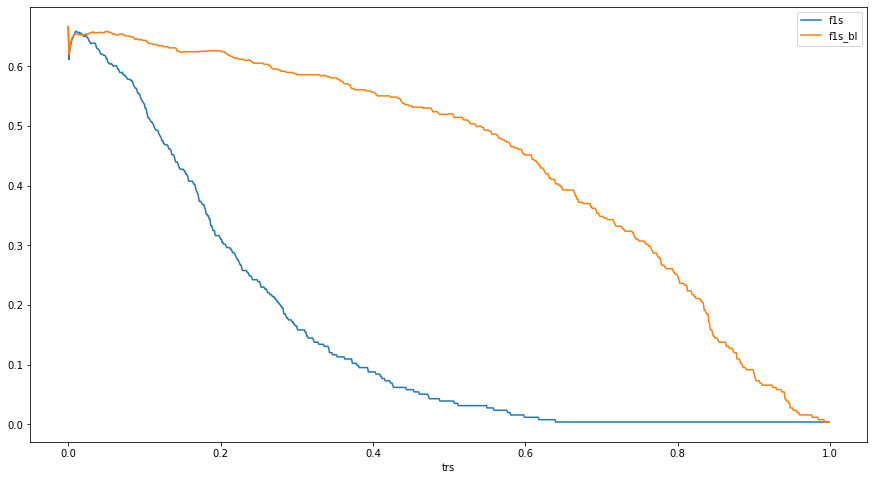

In [512]:
df_scores.plot(x= 'trs',y=['f1s', 'f1s_bl'], figsize=(15, 8))

In [513]:
df_scores.describe()

,trs,precs,recs,accs,f1s,precs_bl,recs_bl,accs_bl,f1s_bl
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.499500,0.994611,0.098298,0.547331,0.149894,0.967628,0.307984,0.646353,0.439585
std,0.288819,0.025935,0.148027,0.069298,0.203107,0.030695,0.160605,0.073881,0.201055
min,0.000000,0.500000,0.002000,0.500000,0.003992,0.500000,0.002000,0.500000,0.003992
25%,0.249750,1.000000,0.002000,0.501000,0.003992,0.958333,0.182000,0.590000,0.307432
50%,0.499500,1.000000,0.020000,0.510000,0.039216,0.966942,0.356000,0.671000,0.519708
75%,0.749250,1.000000,0.136000,0.568000,0.239437,0.988269,0.442000,0.712000,0.605479
max,0.999000,1.000000,1.000000,0.736000,0.666667,1.000000,1.000000,0.736000,0.666667


In [514]:
df_scores[(df_scores['accs'] == df_scores['accs'].max())]

,trs,precs,recs,accs,f1s,precs_bl,recs_bl,accs_bl,f1s_bl
23,0.023,0.953846,0.496,0.736,0.652632,0.895833,0.516,0.728,0.654822


In [515]:
df_scores[df_scores['f1s_bl'] == df_scores['f1s_bl'].max()]

,trs,precs,recs,accs,f1s,precs_bl,recs_bl,accs_bl,f1s_bl
0,0.0,0.5,1.0,0.5,0.666667,0.5,1.0,0.5,0.666667


In [516]:
tr_train = kl_train.mean() + 1 * kl_train.std()
tr_train

0.06732979603111744

In [517]:
df_scores[((df_scores['trs'] > tr_train - 0.01) & (df_scores['trs'] < tr_train + 0.01))]

,trs,precs,recs,accs,f1s,precs_bl,recs_bl,accs_bl,f1s_bl
58,0.058,0.964758,0.438,0.711,0.602476,0.930147,0.506,0.734,0.655440
59,0.059,0.964602,0.436,0.710,0.600551,0.929889,0.504,0.733,0.653696
60,0.060,0.964602,0.436,0.710,0.600551,0.933333,0.504,0.734,0.654545
61,0.061,0.968889,0.436,0.711,0.601379,0.933333,0.504,0.734,0.654545
62,0.062,0.968889,0.436,0.711,0.601379,0.933086,0.502,0.733,0.652796
63,0.063,0.968889,0.436,0.711,0.601379,0.933086,0.502,0.733,0.652796
64,0.064,0.968750,0.434,0.710,0.599448,0.933086,0.502,0.733,0.652796
65,0.065,0.968468,0.430,0.708,0.595568,0.933086,0.502,0.733,0.652796
66,0.066,0.968468,0.430,0.708,0.595568,0.933086,0.502,0.733,0.652796
67,0.067,0.968182,0.426,0.706,0.591667,0.940075,0.502,0.735,0.654498


In [518]:
predict_adv(x_kl, 0.128)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [519]:
predict_adv(x_bl, 0.603)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

### Signal histograms

In [529]:
df_kl = pd.DataFrame()
df_kl['test'] = kl_test
df_kl['adv'] = kl_adv

In [530]:
def _calculate(df_tmp, nb_sigmas=3):
    print(nb_sigmas)
    sp = df_tmp['test'].mean() + (nb_sigmas * df_tmp['adv'].std())
    ps = percentileofscore(df_tmp['adv'], sp) * 0.01
    p = 1 - ps
    return p, sp


In [531]:
_calculate(df_kl)

3


(0.03799999999999992, 2.1279489751905203)

In [532]:
def _calculate_perc(df_t, nb_sigmas=3):
    sigma_plus = df_t['test'].mean() + (nb_sigmas * df_t['test'].std())
    print(sigma_plus)
    pc_sigma = percentileofscore(df_t['adv'], sigma_plus) * 0.01
    perc = 1 - pc_sigma
    return perc, sigma_plus

In [533]:
_calculate_perc(df_kl, nb_sigmas=5)

0.30780581943690777


(0.43600000000000005, 0.30780581943690777)

In [534]:
nb_sigmas = 3
sigma_plus = df_kl['test'].mean() + (nb_sigmas * df_kl['test'].std())
sigma_plus

0.1904639881104231

In [535]:
pc_sigma = percentileofscore(df_kl['adv'], sigma_plus) * 0.01
print('Percentage within {} sigmas: {}'.format(nb_sigmas, pc_sigma))
print('Percentage beyond {} sigmas: {}'.format(nb_sigmas, ( 1 - pc_sigma)))

Percentage within 3 sigmas: 0.53
Percentage beyond 3 sigmas: 0.47


In [536]:
df_kl.describe(percentiles=[0.5, 0.9, pc_sigma])

,test,adv
count,5.000000e+02,5.000000e+02
mean,1.445124e-02,4.957928e-01
std,5.867092e-02,7.044992e-01
min,6.305546e-07,6.024624e-07
50%,5.059189e-04,9.758302e-02
53%,6.042482e-04,1.894994e-01
90%,2.476254e-02,1.451635e+00
max,5.965726e-01,5.080141e+00


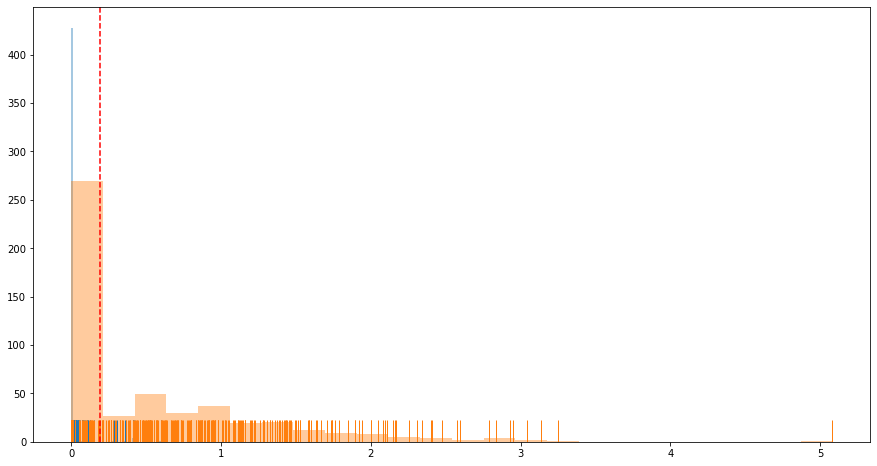

In [537]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.distplot(kl_test, rug=True, ax=ax, kde=False)
plt.axvline(sigma_plus, c='r', linestyle='dashed')
sns.distplot(kl_adv, rug=True,ax=ax, kde=False)

### Sudden drift

In [538]:
df = sst.make_data_stream(kl_concat, agg='mean')

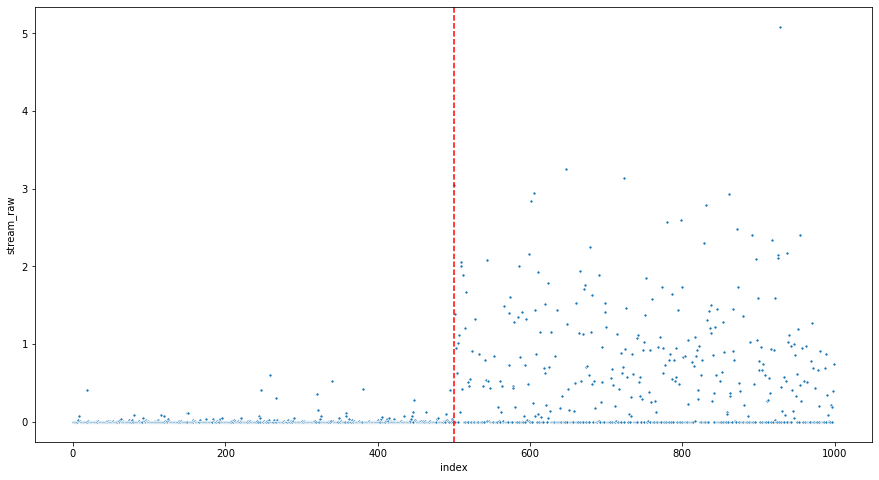

In [539]:
plt.figure(figsize=(15,8))
sns.scatterplot( x="index", y="stream_raw", data=df.reset_index(), s=10)
ax.set(ylim=(-0.1, None))
plt.axvline(kl_test.shape[0], c='r', linestyle='dashed')

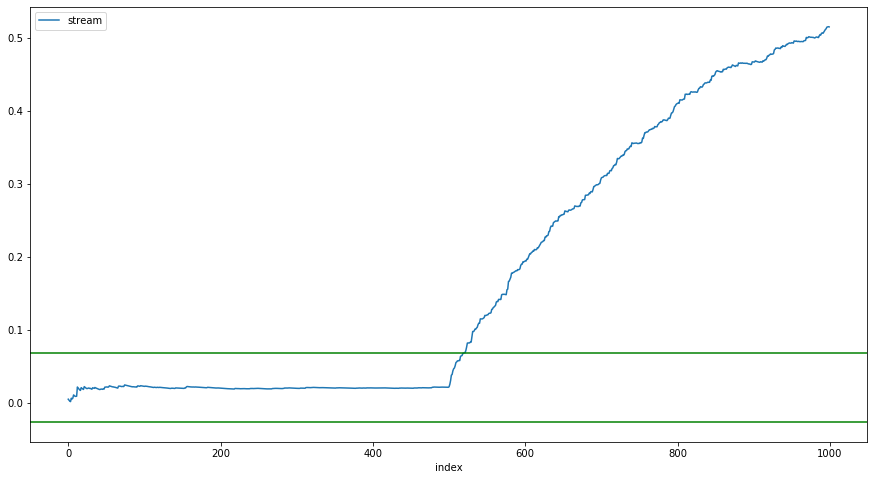

In [501]:
ax = df.plot(x='index', y='stream', figsize=(15,8))
ax.axhline(baseline_std_plus / amp, c='g')
ax.axhline(baseline_std_minus / amp, c='g')

In [502]:
adwin = ADWIN(delta=0.002)
data_stream = df['stream']
for i in range(len(data_stream)):
    adwin.add_element(data_stream[i])
    if adwin.detected_change():
        if i < tr:
            print(Fore.RED + 'Change detected in data: ' + str(data_stream[i]) + ' - at index: ' + str(i))
        else:
            print(Fore.GREEN + 'Change detected in data: ' + str(data_stream[i]) + ' - at index: ' + str(i))

Change detected in data: 0.2696454060101063 - at index: 671
Change detected in data: 0.3100991105056207 - at index: 703
Change detected in data: 0.37576875560270995 - at index: 767
Change detected in data: 0.43239639261006874 - at index: 831
Change detected in data: 0.4635312301091206 - at index: 895
Change detected in data: 0.494832506138729 - at index: 959


### Gradual drift

In [503]:
cd_start = 2000
cd_full = int(2 * cd_start)
nb_samples_tot = 6000
start = 0
df = sst.rolling_stats(vae_loaded, X_test, y_test, X_test_adv, y_test_adv, cd_start, cd_full, nb_samples_tot, start, amp=amp)

Sample 0 of 6000
Sample 1000 of 6000
Sample 2000 of 6000
Sample 3000 of 6000
Sample 4000 of 6000
Sample 5000 of 6000


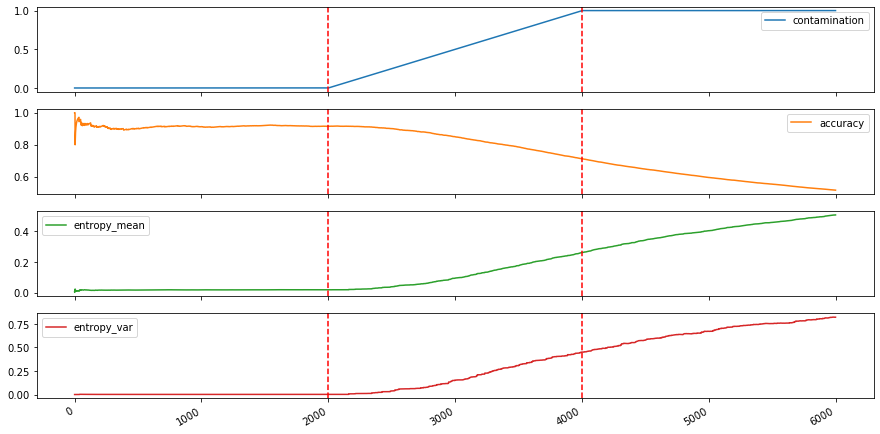

In [504]:
axs = df[['contamination', 'accuracy','entropy_mean', 'entropy_var']].plot(logy = False, subplots=True, figsize = (15, 8))
for ax in axs:
    ax.axvline(cd_start, c='r', linestyle='dashed')
    ax.axvline(cd_full, c='r', linestyle='dashed')

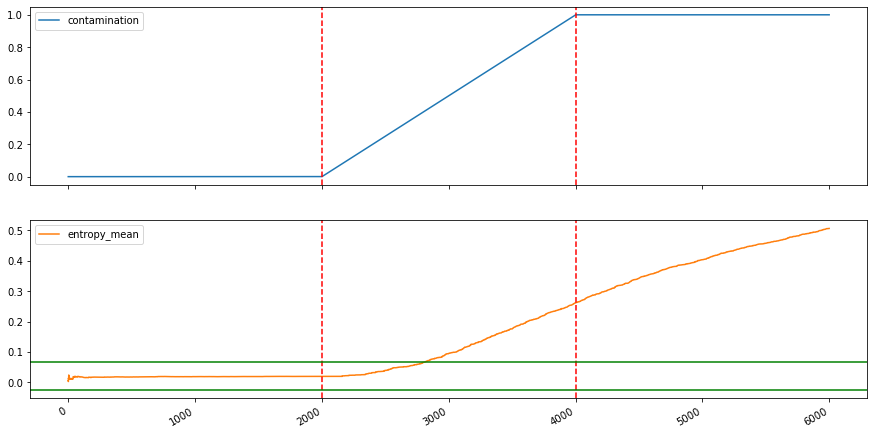

In [505]:
axs = df[['contamination', 'entropy_mean']].plot(logy = False, subplots=True, figsize = (15, 8))
for ax in axs:
    ax.axvline(cd_start, c='r', linestyle='dashed')
    ax.axvline(cd_full, c='r', linestyle='dashed')
axs[1].axhline(baseline_std_plus / amp, c='g')
axs[1].axhline(baseline_std_minus / amp, c='g')


In [506]:
data_stream = df['entropy_mean']
adwin = ADWIN(delta=0.002)
for i in range(len(data_stream)):
    adwin.add_element(data_stream[i])
    if adwin.detected_change():
        if i < cd_start:
            print(Fore.RED + 'Change detected in data: ' + str(data_stream[i]) + ' - at index: ' + str(i))
        elif i >= cd_start and i < cd_full:
            print(Fore.YELLOW + 'Change detected in data: ' + str(data_stream[i]) + ' - at index: ' + str(i))            
        else:
            print(Fore.GREEN + 'Change detected in data: ' + str(data_stream[i]) + ' - at index: ' + str(i))

Change detected in data: 0.07727493259945081 - at index: 2879
Change detected in data: 0.08362605850584762 - at index: 2943
Change detected in data: 0.0965120571033726 - at index: 3007
Change detected in data: 0.10276736182720451 - at index: 3071
Change detected in data: 0.10834383570787796 - at index: 3103
Change detected in data: 0.12622644617727968 - at index: 3199
Change detected in data: 0.1488435496468029 - at index: 3327
Change detected in data: 0.1651915378163345 - at index: 3423
Change detected in data: 0.1819872262451368 - at index: 3519
Change detected in data: 0.20454628925812746 - at index: 3647
Change detected in data: 0.2264336702553332 - at index: 3775
Change detected in data: 0.24319365873866675 - at index: 3903
Change detected in data: 0.2716480741772521 - at index: 4063
Change detected in data: 0.2934560557205074 - at index: 4191
Change detected in data: 0.3190551284347962 - at index: 4351
Change detected in data: 0.33891774173071143 - at index: 4479
Change detected 

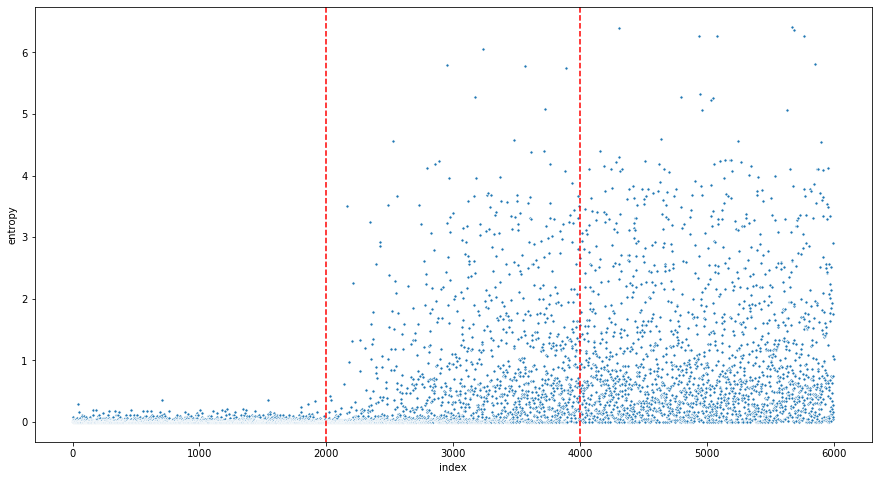

In [507]:
plt.figure(figsize=(15,8))
sns.scatterplot( x="index", y="entropy", data=df.reset_index(), s=10)
ax.set(ylim=(-0.1, None))
plt.axvline(cd_start, c='r', linestyle='dashed')
plt.axvline(cd_full, c='r', linestyle='dashed')

# Cifar

In [3]:
NB_EPOCHS = 20
BATCH_SIZE = 128
LEARNING_RATE = 0.001
CLEAN_TRAIN = True
BACKPROP_THROUGH_ATTACK = False
NB_FILTERS = 64

In [4]:
train_start=0
train_end=60000
test_start=0                 
test_end=10000
nb_epochs=NB_EPOCHS
batch_size=BATCH_SIZE
learning_rate=LEARNING_RATE
clean_train=CLEAN_TRAIN
testing=False
backprop_through_attack=BACKPROP_THROUGH_ATTACK
nb_filters=NB_FILTERS
num_threads=None
label_smoothing=0.1

In [5]:
report = AccuracyReport()

  # Set TF random seed to improve reproducibility
tf.set_random_seed(1234)

  # Set logging level to see debug information
set_log_level(logging.DEBUG)

  # Create TF session
if num_threads:
    config_args = dict(intra_op_parallelism_threads=1)
else:
    config_args = {}
sess = tf.Session(config=tf.ConfigProto(**config_args))

  # Get CIFAR10 data
data = CIFAR10(train_start=train_start, train_end=train_end,
                 test_start=test_start, test_end=test_end)
dataset_size = data.x_train.shape[0]
dataset_train = data.to_tensorflow()[0]
dataset_train = dataset_train.map(
      lambda x, y: (random_shift(random_horizontal_flip(x)), y), 4)
dataset_train = dataset_train.batch(batch_size)
dataset_train = dataset_train.prefetch(16)
X_train, y_train = data.get_set('train')
X_test, y_test = data.get_set('test')

  # Use Image Parameters
img_rows, img_cols, nchannels = X_test.shape[1:4]
nb_classes = y_test.shape[1]

  # Define input TF placeholder
x_pl = tf.placeholder(tf.float32, shape=(None, img_rows, img_cols,
                                        nchannels))
y_pl = tf.placeholder(tf.float32, shape=(None, nb_classes))

  # Train an MNIST model
train_params = {
      'nb_epochs': nb_epochs,
      'batch_size': batch_size,
      'learning_rate': learning_rate
  }
eval_params = {'batch_size': batch_size}
fgsm_params = {
      'eps': 0.3,
      'clip_min': 0.,
      'clip_max': 1.
  }
rng = np.random.RandomState([2017, 8, 30])

def do_eval(preds, x_set, y_set, report_key, is_adv=None):
    acc = model_eval(sess, x_pl, y_pl, preds, x_set, y_set, args=eval_params)
    setattr(report, report_key, acc)
    if is_adv is None:
        report_text = None
    elif is_adv:
        report_text = 'adversarial'
    else:
        report_text = 'legitimate'
    if report_text:
        print('Test accuracy on %s examples: %0.4f' % (report_text, acc))

if clean_train:
    model = ModelAllConvolutional('model1', nb_classes, nb_filters,
                                  input_shape=[32, 32, 3])
    preds = model.get_logits(x_pl)
    loss = CrossEntropy(model, smoothing=label_smoothing)

def evaluate():
    do_eval(preds, X_test, y_test, 'clean_train_clean_eval', False)

train(sess, loss, None, None,
          dataset_train=dataset_train, dataset_size=dataset_size,
          evaluate=evaluate, args=train_params, rng=rng,
          var_list=model.get_params())

    # Calculate training error
if testing:
    do_eval(preds, X_train, y_train, 'train_clean_train_clean_eval')

    # Initialize the Fast Gradient Sign Method (FGSM) attack object and
    # graph
fgsm = FastGradientMethod(model, sess=sess)
adv_x = fgsm.generate(x_pl, **fgsm_params)
preds_adv = model.get_logits(adv_x)

    # Evaluate the accuracy of the MNIST model on adversarial examples
do_eval(preds_adv, X_test, y_test, 'clean_train_adv_eval', True)

    # Calculate training error
if testing:
    do_eval(preds_adv, X_train, y_train, 'train_clean_train_adv_eval')

print('Repeating the process, using adversarial training')

  # Create a new model and train it to be robust to FastGradientMethod
model2 = ModelAllConvolutional('model2', nb_classes, nb_filters,
                                 input_shape=[32, 32, 3])
fgsm2 = FastGradientMethod(model2, sess=sess)

def attack(x):
    return fgsm2.generate(x, **fgsm_params)

loss2 = CrossEntropy(model2, smoothing=label_smoothing, attack=attack)
preds2 = model2.get_logits(x_pl)
adv_x2 = attack(x_pl)

if not backprop_through_attack:
    # For the fgsm attack used in this tutorial, the attack has zero
    # gradient so enabling this flag does not change the gradient.
    # For some other attacks, enabling this flag increases the cost of
    # training, but gives the defender the ability to anticipate how
    # the atacker will change their strategy in response to updates to
    # the defender's parameters.
    adv_x2 = tf.stop_gradient(adv_x2)
preds2_adv = model2.get_logits(adv_x2)

def evaluate2():
    # Accuracy of adversarially trained model on legitimate test inputs
    do_eval(preds2, X_test, y_test, 'adv_train_clean_eval', False)
    # Accuracy of the adversarially trained model on adversarial examples
    do_eval(preds2_adv, X_test, y_test, 'adv_train_adv_eval', True)

  # Perform and evaluate adversarial training
train(sess, loss2, None, None,
        dataset_train=dataset_train, dataset_size=dataset_size,
        evaluate=evaluate2, args=train_params, rng=rng,
        var_list=model2.get_params())

  # Calculate training errors
if testing:
    do_eval(preds2, X_train, y_train, 'train_adv_train_clean_eval')
    do_eval(preds2_adv, X_train, y_train, 'train_adv_train_adv_eval')
print('Done')

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
num_devices:  1


[INFO 2019-10-28 15:07:10,241 cleverhans] Epoch 0 took 12.679786205291748 seconds


Test accuracy on legitimate examples: 0.4872


[INFO 2019-10-28 15:07:22,552 cleverhans] Epoch 1 took 11.483542680740356 seconds


Test accuracy on legitimate examples: 0.6485


[INFO 2019-10-28 15:07:34,836 cleverhans] Epoch 2 took 11.510642051696777 seconds


Test accuracy on legitimate examples: 0.6967


[INFO 2019-10-28 15:07:47,157 cleverhans] Epoch 3 took 11.542885065078735 seconds


Test accuracy on legitimate examples: 0.7551


[INFO 2019-10-28 15:07:59,436 cleverhans] Epoch 4 took 11.509101867675781 seconds


Test accuracy on legitimate examples: 0.7872


[INFO 2019-10-28 15:08:11,738 cleverhans] Epoch 5 took 11.523093223571777 seconds


Test accuracy on legitimate examples: 0.7849


[INFO 2019-10-28 15:08:24,031 cleverhans] Epoch 6 took 11.521440982818604 seconds


Test accuracy on legitimate examples: 0.8188


[INFO 2019-10-28 15:08:36,325 cleverhans] Epoch 7 took 11.515643119812012 seconds


Test accuracy on legitimate examples: 0.8269


[INFO 2019-10-28 15:08:48,621 cleverhans] Epoch 8 took 11.517538785934448 seconds


Test accuracy on legitimate examples: 0.8330


[INFO 2019-10-28 15:09:00,910 cleverhans] Epoch 9 took 11.514426946640015 seconds


Test accuracy on legitimate examples: 0.8372


[INFO 2019-10-28 15:09:13,230 cleverhans] Epoch 10 took 11.54538631439209 seconds


Test accuracy on legitimate examples: 0.8457


[INFO 2019-10-28 15:09:25,519 cleverhans] Epoch 11 took 11.514847993850708 seconds


Test accuracy on legitimate examples: 0.8535


[INFO 2019-10-28 15:09:37,809 cleverhans] Epoch 12 took 11.514491081237793 seconds


Test accuracy on legitimate examples: 0.8566


[INFO 2019-10-28 15:09:50,194 cleverhans] Epoch 13 took 11.605460166931152 seconds


Test accuracy on legitimate examples: 0.8644


[INFO 2019-10-28 15:10:02,544 cleverhans] Epoch 14 took 11.566495656967163 seconds


Test accuracy on legitimate examples: 0.8652


[INFO 2019-10-28 15:10:14,863 cleverhans] Epoch 15 took 11.54585313796997 seconds


Test accuracy on legitimate examples: 0.8647


[INFO 2019-10-28 15:10:27,154 cleverhans] Epoch 16 took 11.517215728759766 seconds


Test accuracy on legitimate examples: 0.8776


[INFO 2019-10-28 15:10:39,476 cleverhans] Epoch 17 took 11.54130744934082 seconds


Test accuracy on legitimate examples: 0.8673


[INFO 2019-10-28 15:10:51,794 cleverhans] Epoch 18 took 11.537827014923096 seconds


Test accuracy on legitimate examples: 0.8745


[INFO 2019-10-28 15:11:04,115 cleverhans] Epoch 19 took 11.551781415939331 seconds


Test accuracy on legitimate examples: 0.8773


/home/Gigio/git/fork-cleverhans/cleverhans/attacks_tf.py:27: UserWarning: attacks_tf is deprecated and will be removed on 2019-07-18 or after. Code should import functions from their new locations directly.
  warnings.warn("attacks_tf is deprecated and will be removed on 2019-07-18"
/home/Gigio/git/fork-cleverhans/cleverhans/compat.py:22: UserWarning: <function reduce_max at 0x7f43154f52f0> is deprecated. Switch to calling the equivalent function in tensorflow.  This function was originally needed as a compatibility layer for old versions of tensorflow,  but support for those versions has now been dropped.
  warnings.warn(str(f) + " is deprecated. Switch to calling the equivalent function in tensorflow. "
/home/Gigio/git/fork-cleverhans/cleverhans/compat.py:22: UserWarning: <function reduce_sum at 0x7f43154eea60> is deprecated. Switch to calling the equivalent function in tensorflow.  This function was originally needed as a compatibility layer for old versions of tensorflow,  but supp

Test accuracy on adversarial examples: 0.1027
Repeating the process, using adversarial training


/home/Gigio/git/fork-cleverhans/cleverhans/loss.py:41: UserWarning: callable attacks are deprecated, switch to an Attack subclass. callable attacks will not be supported after 2019-05-05.
  warnings.warn("callable attacks are deprecated, switch to an Attack "


num_devices:  1


[INFO 2019-10-28 15:11:38,225 cleverhans] Epoch 0 took 27.71207332611084 seconds


Test accuracy on legitimate examples: 0.3618
Test accuracy on adversarial examples: 0.1714


[INFO 2019-10-28 15:12:09,264 cleverhans] Epoch 1 took 27.38006353378296 seconds


Test accuracy on legitimate examples: 0.5990
Test accuracy on adversarial examples: 0.4311


[INFO 2019-10-28 15:12:39,965 cleverhans] Epoch 2 took 27.481393098831177 seconds


Test accuracy on legitimate examples: 0.6708
Test accuracy on adversarial examples: 0.5467


[INFO 2019-10-28 15:13:10,612 cleverhans] Epoch 3 took 27.433262586593628 seconds


Test accuracy on legitimate examples: 0.7265
Test accuracy on adversarial examples: 0.5975


[INFO 2019-10-28 15:13:41,310 cleverhans] Epoch 4 took 27.475255012512207 seconds


Test accuracy on legitimate examples: 0.7259
Test accuracy on adversarial examples: 0.6364


[INFO 2019-10-28 15:14:12,028 cleverhans] Epoch 5 took 27.489441871643066 seconds


Test accuracy on legitimate examples: 0.7585
Test accuracy on adversarial examples: 0.6887


[INFO 2019-10-28 15:14:42,711 cleverhans] Epoch 6 took 27.46079397201538 seconds


Test accuracy on legitimate examples: 0.7919
Test accuracy on adversarial examples: 0.7023


[INFO 2019-10-28 15:15:13,445 cleverhans] Epoch 7 took 27.510754346847534 seconds


Test accuracy on legitimate examples: 0.8037
Test accuracy on adversarial examples: 0.7250


[INFO 2019-10-28 15:15:44,140 cleverhans] Epoch 8 took 27.462427377700806 seconds


Test accuracy on legitimate examples: 0.8173
Test accuracy on adversarial examples: 0.7428


[INFO 2019-10-28 15:16:14,819 cleverhans] Epoch 9 took 27.458906650543213 seconds


Test accuracy on legitimate examples: 0.8068
Test accuracy on adversarial examples: 0.7573


[INFO 2019-10-28 15:16:45,517 cleverhans] Epoch 10 took 27.478805780410767 seconds


Test accuracy on legitimate examples: 0.8158
Test accuracy on adversarial examples: 0.7593


[INFO 2019-10-28 15:17:16,189 cleverhans] Epoch 11 took 27.4525408744812 seconds


Test accuracy on legitimate examples: 0.8309
Test accuracy on adversarial examples: 0.7570


[INFO 2019-10-28 15:17:46,887 cleverhans] Epoch 12 took 27.47890830039978 seconds


Test accuracy on legitimate examples: 0.8311
Test accuracy on adversarial examples: 0.7849


[INFO 2019-10-28 15:18:17,605 cleverhans] Epoch 13 took 27.486246824264526 seconds


Test accuracy on legitimate examples: 0.8466
Test accuracy on adversarial examples: 0.8163


[INFO 2019-10-28 15:18:48,288 cleverhans] Epoch 14 took 27.45728588104248 seconds


Test accuracy on legitimate examples: 0.8439
Test accuracy on adversarial examples: 0.8087


[INFO 2019-10-28 15:19:18,987 cleverhans] Epoch 15 took 27.480610132217407 seconds


Test accuracy on legitimate examples: 0.8408
Test accuracy on adversarial examples: 0.7912


[INFO 2019-10-28 15:19:49,710 cleverhans] Epoch 16 took 27.484564542770386 seconds


Test accuracy on legitimate examples: 0.8472
Test accuracy on adversarial examples: 0.8192


[INFO 2019-10-28 15:20:20,515 cleverhans] Epoch 17 took 27.56053590774536 seconds


Test accuracy on legitimate examples: 0.8532
Test accuracy on adversarial examples: 0.8185


[INFO 2019-10-28 15:20:51,207 cleverhans] Epoch 18 took 27.461504459381104 seconds


Test accuracy on legitimate examples: 0.8657
Test accuracy on adversarial examples: 0.8359


[INFO 2019-10-28 15:21:21,912 cleverhans] Epoch 19 took 27.46008038520813 seconds


Test accuracy on legitimate examples: 0.8505
Test accuracy on adversarial examples: 0.8150
Done


In [9]:
X_adv = sess.run(fgsm.generate(x_pl, sess=sess), feed_dict={x_pl: X_test[:1000]})
y_adv = y_test

/home/Gigio/git/fork-cleverhans/cleverhans/attacks/fast_gradient_method.py:122: UserWarning: kwargs is unused and will be removed on or after 2019-04-26.
  warnings.warn("kwargs is unused and will be removed on or after "
/home/Gigio/git/fork-cleverhans/cleverhans/compat.py:22: UserWarning: <function reduce_max at 0x7f43154f52f0> is deprecated. Switch to calling the equivalent function in tensorflow.  This function was originally needed as a compatibility layer for old versions of tensorflow,  but support for those versions has now been dropped.
  warnings.warn(str(f) + " is deprecated. Switch to calling the equivalent function in tensorflow. "
/home/Gigio/git/fork-cleverhans/cleverhans/compat.py:22: UserWarning: <function reduce_sum at 0x7f43154eea60> is deprecated. Switch to calling the equivalent function in tensorflow.  This function was originally needed as a compatibility layer for old versions of tensorflow,  but support for those versions has now been dropped.
  warnings.warn(s

Sample instance from the MNIST data set.


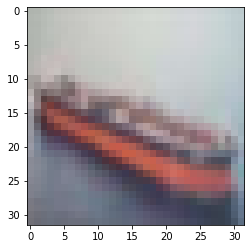

In [10]:
idx = 999
x = X_test[idx: idx + 1]
plt.imshow(np.squeeze(x), 'gray')
print('Sample instance from the MNIST data set.')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Sample instance from the MNIST data set.


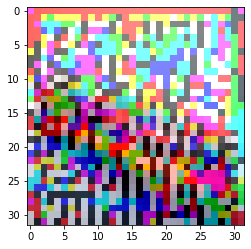

In [11]:
xa = X_adv[idx: idx + 1]
plt.imshow(np.squeeze(xa), 'gray')
print('Sample instance from the MNIST data set.')

In [34]:
sess.run(model.get_probs(x_pl), feed_dict={x_pl: x})

array([[0.02680327, 0.00680656, 0.00422867, 0.00439995, 0.00276608,
        0.00228287, 0.00274207, 0.00228873, 0.94373333, 0.00394845]],
      dtype=float32)

In [35]:
sess.run(model.get_probs(x_pl), feed_dict={x_pl: xa})

array([[0.03669943, 0.3080798 , 0.01204626, 0.01754826, 0.0241965 ,
        0.02278983, 0.04068958, 0.08311906, 0.05236148, 0.4024698 ]],
      dtype=float32)

## Train vae

In [301]:
vae = vsf.VaeSymmetryFinderConv(model, input_shape=(28, 28, 1), rgb_filters=1,
                            output_shape=(10, ), 
                            intermediate_dim=256, 
                            latent_dim=8, loss_type='symm')

Vae
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_32 (Conv2D)              (None, 14, 14, 64)   640         encoder_input[0][0]              
__________________________________________________________________________________________________
dropout_28 (Dropout)            (None, 14, 14, 64)   0           conv2d_32[0][0]                  
__________________________________________________________________________________________________
conv2d_33 (Conv2D)              (None, 7, 7, 128)    73856       dropout_28[0][0]                 
__________________________________________________________________________________________________
dropou

In [302]:
vae.fit(X_train, x_test=X_test, epochs=50)

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 12s 203us/step - loss: 0.6234 - val_loss: 0.1506
Epoch 2/50
60000/60000 [==============================] - 9s 142us/step - loss: 0.1363 - val_loss: 0.0974
Epoch 3/50
60000/60000 [==============================] - 9s 142us/step - loss: 0.0929 - val_loss: 0.0772
Epoch 4/50
60000/60000 [==============================] - 9s 142us/step - loss: 0.0726 - val_loss: 0.0677
Epoch 5/50
60000/60000 [==============================] - 9s 142us/step - loss: 0.0617 - val_loss: 0.0590
Epoch 6/50
60000/60000 [==============================] - 9s 142us/step - loss: 0.0552 - val_loss: 0.0583
Epoch 7/50
60000/60000 [==============================] - 9s 142us/step - loss: 0.0497 - val_loss: 0.0561
Epoch 8/50
60000/60000 [==============================] - 9s 142us/step - loss: 0.0464 - val_loss: 0.0568
Epoch 9/50
60000/60000 [==============================] - 9s 143us/step - loss: 0.0442 - val_loss: 0.

In [303]:
vae.save(arch_path='vae_arch_mnist_adv.json', weights_path='vae_weights_mnist_adv.h5')

In [304]:
vae_loaded = vsf.load_vae(arch_path='vae_arch_mnist_adv.json', weights_path='vae_weights_mnist_adv.h5')

Loaded model from disk


## Stream

In [305]:
# Symmetry signal
X_train_perm = np.random.permutation(X_train)
X_test_perm = np.random.permutation(X_test)
X_adv_perm = np.random.permutation(X_adv)

amp = 0.5
kl_train = vae_loaded.signal(X_train_perm, amp=amp)
kl_test = vae_loaded.signal(X_test_perm, amp=amp)
kl_adv = vae_loaded.signal(X_adv_perm, amp=amp)

baseline_std_plus = kl_train.mean() + kl_train.std()
baseline_std_minus = kl_train.mean() - kl_train.std()

kl_concat = np.concatenate((kl_test, kl_adv))
tr = kl_test.shape[0]

In [306]:
vae.predict_original(x)

array([[0.00944898, 0.00931012, 0.01011397, 0.9144536 , 0.010226  ,
        0.00875417, 0.00966593, 0.00902877, 0.00955911, 0.0094393 ]],
      dtype=float32)

In [307]:
vae.transform_predict(x)

array([[0.00939064, 0.00621081, 0.01904817, 0.8708233 , 0.00673245,
        0.03239373, 0.01086471, 0.01453625, 0.01853919, 0.0114607 ]],
      dtype=float32)

In [308]:
vae.predict_original(xa)

array([[0.06550434, 0.05473979, 0.15493904, 0.12586369, 0.09562235,
        0.15378147, 0.07624201, 0.09200393, 0.08536093, 0.09594247]],
      dtype=float32)

In [309]:
vae.transform_predict(xa)

array([[0.00948455, 0.00613334, 0.01946554, 0.8695392 , 0.00683212,
        0.03270752, 0.01098244, 0.01475581, 0.01867487, 0.0114246 ]],
      dtype=float32)

In [310]:
kl_test.mean() + 2 * kl_test.std()

0.24636141769587994

In [317]:
df_kl = pd.DataFrame()
df_kl['test'] = - kl_test
df_kl['adv'] = - kl_adv

In [322]:
nb_sigmas = 3
sigma_plus = -(kl_test.mean() + nb_sigmas * kl_test.std())

In [323]:
pc_sigma = percentileofscore(df_kl['adv'], sigma_plus) * 0.01

In [324]:
sigma_plus

-0.3577089589089155

In [325]:
pc_sigma

0.9056000000000001

In [326]:
df_kl.describe(percentiles=[0.5, 0.9, pc_sigma])

,test,adv
count,10000.000000,10000.000000
mean,-0.023666,-0.709786
std,0.111353,0.225571
min,-1.897678,-1.371375
50%,-0.000577,-0.774687
90%,-0.000119,-0.368525
90.6%,-0.000114,-0.357703
max,-0.000007,-0.019792


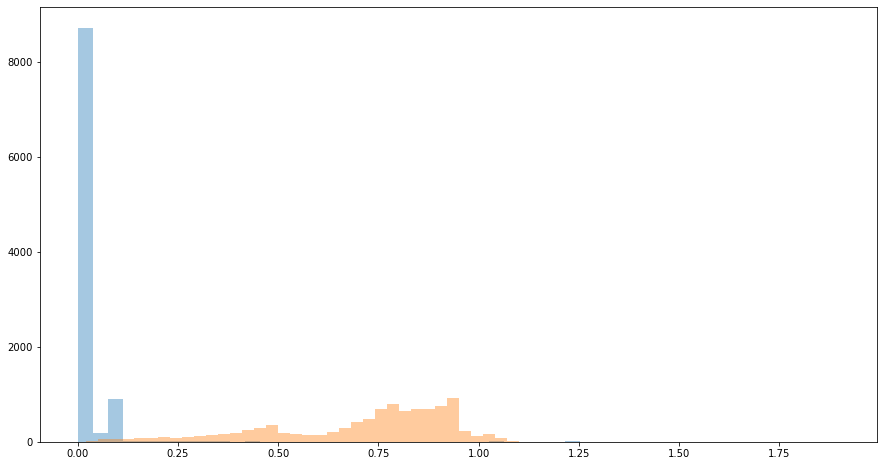

In [327]:
fig, ax = plt.subplots(figsize=(15, 8))
sns.distplot(kl_test, ax=ax, kde=False)
sns.distplot(kl_adv, ax=ax, kde=False)

### Sudden drift

In [328]:
df = sst.make_data_stream(kl_concat, agg='mean')

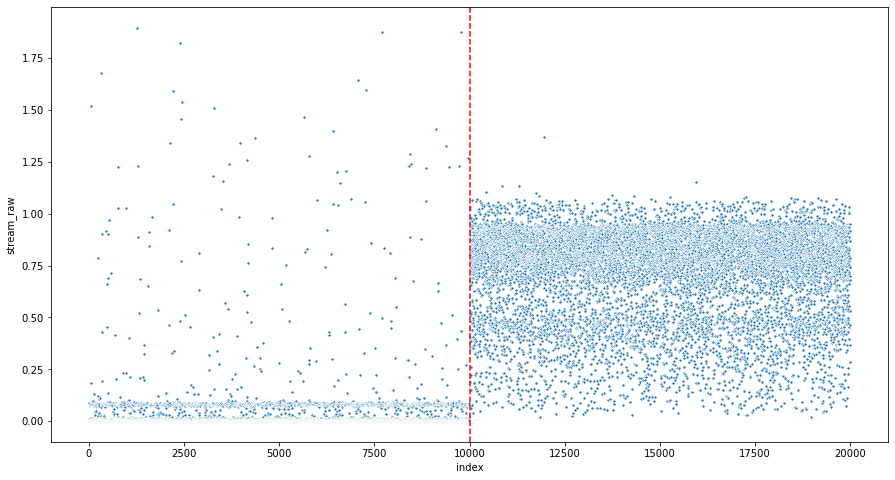

In [329]:
plt.figure(figsize=(15,8))
sns.scatterplot( x="index", y="stream_raw", data=df.reset_index(), s=10)
ax.set(ylim=(-0.1, None))
plt.axvline(tr, c='r', linestyle='dashed')

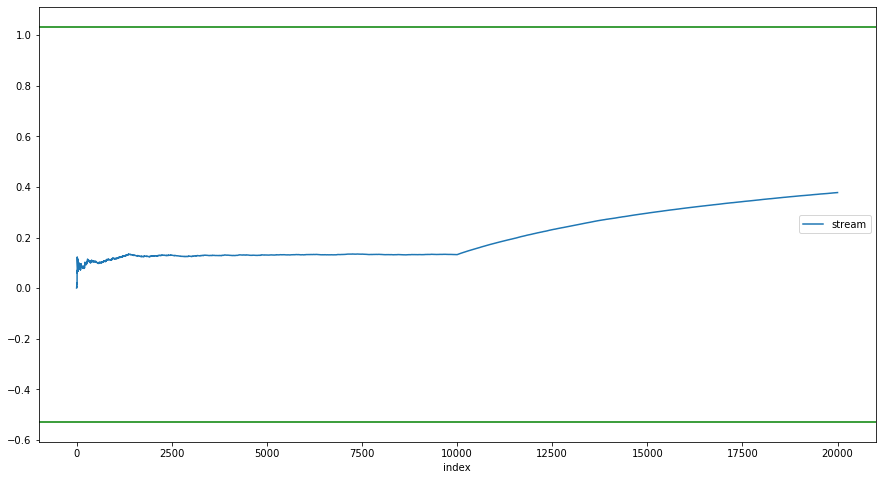

In [275]:
ax = df.plot(x='index', y='stream', figsize=(15,8))
ax.axhline(baseline_std_plus / amp, c='g')
ax.axhline(baseline_std_minus / amp, c='g')

In [276]:
adwin = ADWIN(delta=0.002)
data_stream = df['stream']
for i in range(len(data_stream)):
    adwin.add_element(data_stream[i])
    if adwin.detected_change():
        if i < tr:
            print(Fore.RED + 'Change detected in data: ' + str(data_stream[i]) + ' - at index: ' + str(i))
        else:
            print(Fore.GREEN + 'Change detected in data: ' + str(data_stream[i]) + ' - at index: ' + str(i))

Change detected in data: 0.12986713712040188 - at index: 1535
Change detected in data: 0.13001620659477486 - at index: 2303
Change detected in data: 0.1296612836097956 - at index: 3583
Change detected in data: 0.1431412076843279 - at index: 10207
Change detected in data: 0.15905178767742434 - at index: 10559
Change detected in data: 0.16482531044181042 - at index: 10687
Change detected in data: 0.17024729698717844 - at index: 10815
Change detected in data: 0.17419336049850812 - at index: 10911
Change detected in data: 0.17931640717167727 - at index: 11039
Change detected in data: 0.18047034415918956 - at index: 11071
Change detected in data: 0.1875491626066638 - at index: 11263
Change detected in data: 0.1947314369929331 - at index: 11455
Change detected in data: 0.2007770629511228 - at index: 11615
Change detected in data: 0.2133539487484565 - at index: 11967
Change detected in data: 0.22404959297989246 - at index: 12287
Change detected in data: 0.23240619665297288 - at index: 12543
C

### Gradual drift

In [277]:
cd_start = 2000
cd_full = int(2 * cd_start)
nb_samples_tot = 6000
start = 0
df = sst.rolling_stats(vae_loaded, X_test, y_test, X_adv, y_adv, cd_start, cd_full, nb_samples_tot, start, amp=amp)

Sample 0 of 6000
Sample 1000 of 6000
Sample 2000 of 6000
Sample 3000 of 6000
Sample 4000 of 6000
Sample 5000 of 6000


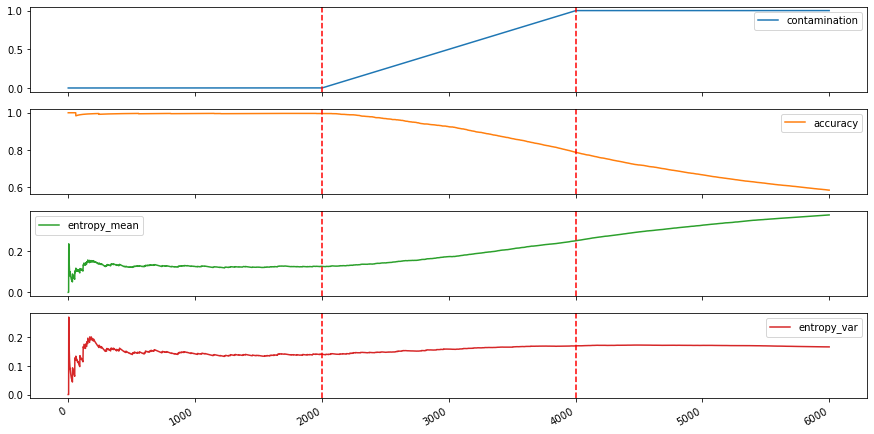

In [278]:
axs = df[['contamination', 'accuracy','entropy_mean', 'entropy_var']].plot(logy = False, subplots=True, figsize = (15, 8))
for ax in axs:
    ax.axvline(cd_start, c='r', linestyle='dashed')
    ax.axvline(cd_full, c='r', linestyle='dashed')

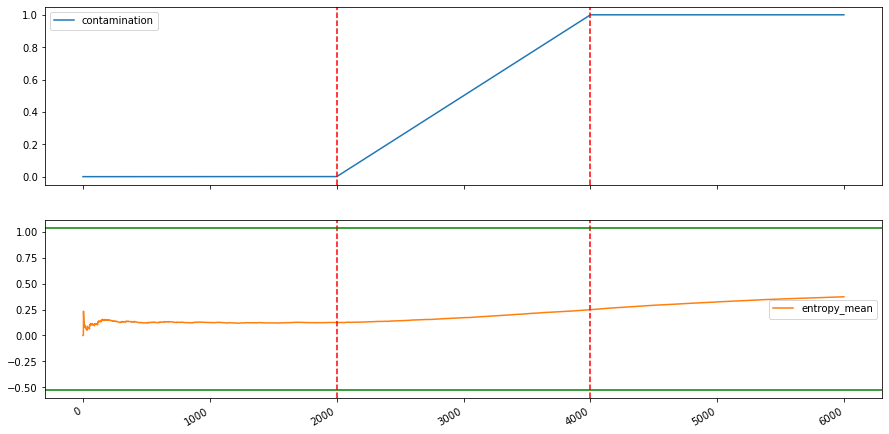

In [279]:
axs = df[['contamination', 'entropy_mean']].plot(logy = False, subplots=True, figsize = (15, 8))
for ax in axs:
    ax.axvline(cd_start, c='r', linestyle='dashed')
    ax.axvline(cd_full, c='r', linestyle='dashed')
axs[1].axhline(baseline_std_plus / amp, c='g')
axs[1].axhline(baseline_std_minus / amp, c='g')


In [280]:
data_stream = df['entropy_mean']
adwin = ADWIN(delta=0.002)
for i in range(len(data_stream)):
    adwin.add_element(data_stream[i])
    if adwin.detected_change():
        if i < cd_start:
            print(Fore.RED + 'Change detected in data: ' + str(data_stream[i]) + ' - at index: ' + str(i))
        elif i >= cd_start and i < cd_full:
            print(Fore.YELLOW + 'Change detected in data: ' + str(data_stream[i]) + ' - at index: ' + str(i))            
        else:
            print(Fore.GREEN + 'Change detected in data: ' + str(data_stream[i]) + ' - at index: ' + str(i))

Change detected in data: 0.16909600499207073 - at index: 2943
Change detected in data: 0.1730277312745748 - at index: 3007
Change detected in data: 0.18059271946378574 - at index: 3135
Change detected in data: 0.19501112986853206 - at index: 3327
Change detected in data: 0.21681595684198937 - at index: 3583
Change detected in data: 0.23332776763244614 - at index: 3807
Change detected in data: 0.23509566379057142 - at index: 3839
Change detected in data: 0.24636344471094118 - at index: 3967
Change detected in data: 0.2584067885163753 - at index: 4095
Change detected in data: 0.2697502076458331 - at index: 4223
Change detected in data: 0.2795744648028703 - at index: 4351
Change detected in data: 0.2901428441167881 - at index: 4479
Change detected in data: 0.2986059893543592 - at index: 4607
Change detected in data: 0.3068827446880567 - at index: 4735
Change detected in data: 0.31737838075892577 - at index: 4895
Change detected in data: 0.327523366162041 - at index: 5055
Change detected i

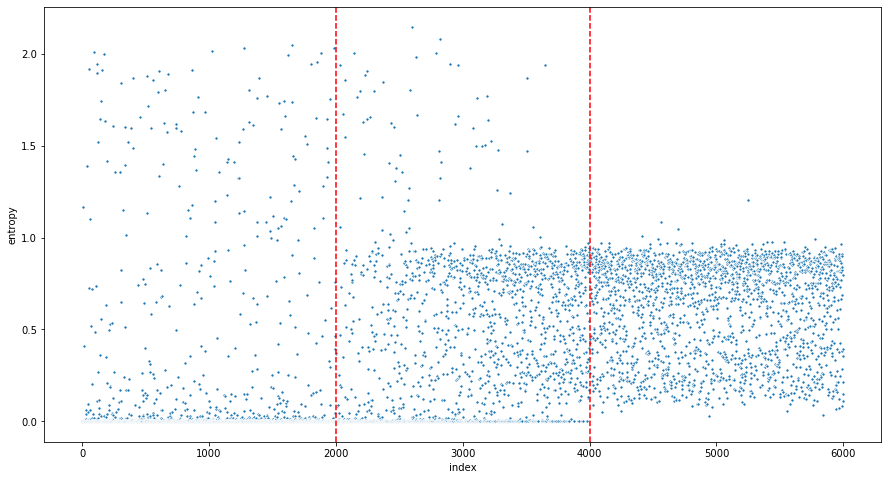

In [281]:
plt.figure(figsize=(15,8))
sns.scatterplot( x="index", y="entropy", data=df.reset_index(), s=10)
ax.set(ylim=(-0.1, None))
plt.axvline(cd_start, c='r', linestyle='dashed')
plt.axvline(cd_full, c='r', linestyle='dashed')